In [ ]:
import cv2
import os
import math


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Bubble:
    def __init__(self):
        self.ID = 0
        self.pos = (0, 0)
        self.pos_list = []
        # пузырь есть на текущем кадре?
        self.off_screen = False

    def __init__(self, ID_, pos_):
        self.ID = ID_
        self.pos = pos_
        self.off_screen = False
        self.pos_list = []
    
    def pos_upd(self, actual_pos):
        self.pos_list.append(self.pos)
        self.pos = actual_pos

    def get_pos_list(self):
        return self.pos_list.copy()

    def disp(self):  
      print('index:', self.index)
      print('center_mass:', self.pos_list)

In [ ]:
class CounterOfBubbles:
    def __init__(self, step_):
        # максимальный приращение перемещения пузыря
        self.step = step_
        self.bubbles = dict()
        self.lastID = 0
        # IDs
        self.bubblesOnScreen = list()


    def update(self, centersOfMass):
        # пытаемся найти старые пузыри
        # если i-ый центр масс - новый, то True
        newBubbles = [True for i in range(len(centersOfMass))]
        
        for b in self.bubblesOnScreen:
            for i in range(len(centersOfMass)):
                distance = math.sqrt((centersOfMass[i][0] - self.bubbles[b].pos[0]) ** 2 + (centersOfMass[i][1] - self.bubbles[b].pos[1]) ** 2)
                if distance < self.step:
                    self.bubbles[b].off_screen = False
                    self.bubbles[b].pos_upd(centersOfMass[i])
                    #print(self.bubbles[b].ID, self.bubbles[b].pos)
                    break
            else:
                # если пузыря больше нет
                self.bubblesOnScreen.remove(b)
                self.bubbles[b].off_screen = True
                #print("less:", self.bubbles[b].ID, self.bubbles[b].pos)
        
        for i in range(len(centersOfMass)):
            for b in self.bubblesOnScreen:
                distance = math.sqrt((centersOfMass[i][0] - self.bubbles[b].pos[0]) ** 2 + (centersOfMass[i][1] - self.bubbles[b].pos[1]) ** 2)
                if distance < self.step:
                    newBubbles[i] = False

        for i in range(len(newBubbles)):
            if newBubbles[i] == True:
                self.bubblesOnScreen.append(self.lastID)
                self.bubbles[self.lastID] = Bubble(self.lastID, centersOfMass[i])
                #print("new:", self.bubbles[self.lastID].ID, self.bubbles[self.lastID].pos)
                self.lastID += 1

    def getStatistics(self):
        return self.bubbles

In [ ]:
class VideoAnalyzer:
    def __init__(self, video_):
        self.video = video_
        self.counter = CounterOfBubbles(60)

    def analyze(self):
        #self.previous = 0
        #self.bubble_counter = 0
        i = 0
        for im in self.video:
            #print()
            #print(i+1)
            i += 1
            ret, thresh = cv2.threshold(im, 127, 255, 0)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            centers = list()
            for c in contours:
                M = cv2.moments(c)
                x = int(M['m10'] / M['m00'])
                y = int(M['m01'] / M['m00'])
                centers.append((x, y))

            self.counter.update(centers)    



In [ ]:
path_to_images = '/content/drive/MyDrive/Dataset/masks/'
images = []
for root, dirs, files in os.walk(path_to_images):
  files.sort()
  for image in files:
       images.append(cv2.imread(path_to_images + image, cv2.IMREAD_GRAYSCALE))


In [ ]:
print(images[0].shape)
videoAnalyzer = VideoAnalyzer(images)
videoAnalyzer.analyze()
print(len(videoAnalyzer.counter.getStatistics()))

(221, 1280)
27


In [ ]:
def fon(images):
  max_image = np.max(images, axis = 0)
  return max_image

In [ ]:
fon = fon(images)

In [ ]:
import numpy as np
from PIL import Image as im

data = im.fromarray(fon)
data.save('/content/drive/MyDrive/csv_test/fon.png')

In [ ]:
#from matplotlib import pyplot as plt
#plt.imshow(fon)
#plt.show()

In [ ]:
import re
import csv
import pandas
import random
import numpy as np 
from PIL import Image
from pandas import DataFrame 
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook 
import matplotlib.image as image 

In [ ]:
path = '/content/drive/MyDrive/csv_test/test.csv'

In [ ]:
bubble_list = []
for i in range (len(videoAnalyzer.counter.getStatistics())):
  bubble_list.append(videoAnalyzer.counter.getStatistics()[i])

In [ ]:
def bubble_to_csv(bubble_list):
  index = []
  center_mass = []


  for bubble in bubble_list:
    index.append(bubble.ID)
    center_mass.append(bubble.pos_list)


  C = {'index': index,       
      'center_mass': center_mass, }

  df = DataFrame(C, columns=['index', 'center_mass']) 
  export_csv = df.to_csv(path, index = None, header = True)

In [ ]:
def parse_csv(csv_file_path):
  result = pandas.read_csv(csv_file_path) 
  print(result)
  print("extracted bubble data:")


In [ ]:
def bubble_extraction_by_index(csv_file_path, i):
  result = pandas.read_csv(csv_file_path) 
  print("here is the bubble with the index", i)
  i -= 1
  print('index:', result['index'][i])
  print('\nthe trajectory of the center of mass:')

  cnt_ms = result['center_mass'][i][1:-1]
  cnt_ms = re.sub("[\)|\ |\[|\]|\(]", "", cnt_ms).split(",")
  cnt_ms = [float(num) for num in cnt_ms]
  x = cnt_ms[::2]
  y = cnt_ms[1::2]
  fig, ax = plt.subplots()
  plt.ylim(0, 221)
  ax.plot(x, y, color="red", label="center_mass")
  plt.show()

In [ ]:
def bubble_extraction_by_index_and_image(csv_file_path, image_path, i):
  result = pandas.read_csv(csv_file_path) 
  print("here is the bubble with the index", i)
  print('index:', result['index'][i])
  print('\nthe trajectory of the center of mass:')

  cnt_ms = result['center_mass'][i][1:-1]
  cnt_ms = re.sub("[\)|\ |\[|\]|\(]", "", cnt_ms).split(",")
  cnt_ms = [float(num) for num in cnt_ms]
  x = cnt_ms[::2]
  y = cnt_ms[1::2]

  img = Image.open(image_path)
  width = img.size[0] 
  height = img.size[1] 

  with cbook.get_sample_data(image_path) as file: 
    im = plt.imread(file) 

  fig, ax = plt.subplots()
  plt.ylim(0, 221)
  ax.plot(x, y, '-o', color="red", label="center_mass")
  fig.figimage(im, 30, 25, alpha = .35) 
  fig = plt.gcf()
  coef = 55
  fig.set_size_inches(width/coef, height/coef)
  plt.show()

In [ ]:
bubble_to_csv(bubble_list)

here is the bubble with the index 3
index: 3

the trajectory of the center of mass:


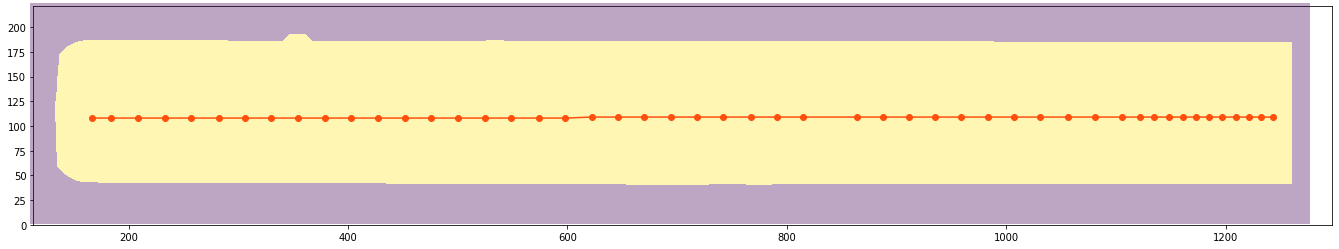

In [ ]:
image_path = '/content/drive/MyDrive/csv_test/fon.png'
bubble_extraction_by_index_and_image(path, image_path, 3)

here is the bubble with the index 3
index: 2

the trajectory of the center of mass:


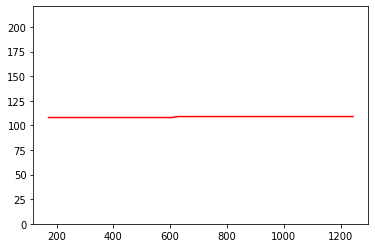

In [ ]:
bubble_extraction_by_index(path, 3)

In [ ]:
parse_csv(path)

    index                                        center_mass
0       0  [(909, 109), (933, 109), (957, 109), (981, 109...
1       1  [(328, 108), (352, 108), (377, 108), (401, 108...
2       2  [(172, 108), (191, 108), (216, 108), (240, 108...
3       3  [(167, 108), (184, 108), (209, 108), (233, 108...
4       4  [(182, 108), (205, 108), (229, 108), (254, 108...
5       5  [(180, 108), (204, 108), (228, 108), (253, 108...
6       6  [(180, 108), (203, 108), (228, 108), (252, 108...
7       7  [(172, 108), (192, 108), (217, 108), (241, 108...
8       8  [(186, 108), (210, 108), (233, 108), (257, 108...
9       9  [(186, 108), (207, 108), (231, 108), (255, 108...
10     10  [(173, 108), (191, 108), (215, 108), (240, 108...
11     11  [(170, 108), (188, 108), (213, 108), (238, 108...
12     12  [(185, 108), (209, 108), (233, 108), (257, 108...
13     13  [(161, 108), (178, 108), (202, 108), (226, 108...
14     14  [(170, 108), (190, 108), (214, 108), (238, 108...
15     15  [(169, 108), 